In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy import stats
from math import pi
from scipy.spatial.distance import cdist
import time

from orbit.models.ktrx import KTRXFull, KTRXAggregated
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data


plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Simulation Modules

In [116]:
def sim_data_seasonal(n, RS):
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': np.sin(2*pi*tau),
        'beta3': np.sin(4*pi*(tau-1/8)),
        'x1': stats.chi2.rvs(4, size=n),
        'x2': stats.t.rvs(2, size=n),
        'x3': stats.t.rvs(2, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 1, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
    
    # hack for p = 3 
    data['beta1'] = beta[:,0]
    data['beta2'] = beta[:,1]
    data['beta3'] = beta[:,2]    
    
    return data

In [118]:
data = sim_data_seasonal(n=300, RS=8888)
# data = sim_data_rw(n=300, RS=8888, p=3)
data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.003333,2018-01-01,0.006667,0.020942,-0.999123,2.380312,-0.724116,-2.805017,1.000000,0.884191,3.687451
1,0.006667,2018-01-02,0.013333,0.041876,-0.996493,3.206075,-0.469831,0.724651,1.057633,0.009109,-0.689927
2,0.010000,2018-01-03,0.020000,0.062791,-0.992115,3.827392,0.151335,1.925227,0.891878,1.768186,-0.055809
3,0.013333,2018-01-04,0.026667,0.083678,-0.985996,14.764097,-0.271283,1.550322,0.967232,-1.507611,-2.665214
4,0.016667,2018-01-05,0.033333,0.104528,-0.978148,1.999616,-0.024061,0.113366,0.869799,-0.181936,-0.228686
5,0.020000,2018-01-06,0.040000,0.125333,-0.968583,3.583398,-0.559756,-1.477073,0.914509,-0.625022,0.878826
6,0.023333,2018-01-07,0.046667,0.146083,-0.957319,8.219563,-0.622302,-0.219984,0.818403,0.296977,0.800244
7,0.026667,2018-01-08,0.053333,0.166769,-0.944376,5.693641,-1.022237,-0.928416,0.764198,0.573434,1.583391
8,0.030000,2018-01-09,0.060000,0.187381,-0.929776,6.801100,1.463764,-1.764239,1.014435,0.805590,3.128286
9,0.033333,2018-01-10,0.066667,0.207912,-0.913545,5.710725,0.202612,-0.738096,1.043174,-0.971990,0.125135


In [147]:
# define stuff 
regressor_col=['x1', 'x2', 'x3']
response_col = 'y'
# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(
    response_col=response_col,
    date_col='date',
    level_knot_scale=1,
    seed=2020,
    span_level= .1, 
    estimator_type=StanEstimatorMAP,
)
ktr_lite.fit(df=data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

In [153]:
%%time
ktrx1 = KTRXFull(
    response_col=response_col,
    date_col='date',
    level_knot_scale=level_knot_scale,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,

    regressor_col=regressor_col,
    regressor_knot_pooling_loc=[0] * len(regressor_col),
    regressor_knot_pooling_scale=[1] * len(regressor_col),
    regressor_knot_scale=[.2] * len(regressor_col),

    span_coefficients=0.1,
    rho_coefficients=0.1, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.01,
    learning_rate_total_decay=1.,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
    mvn=1
)

ktrx1.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1079, scale = 0.10098
step  100 loss = 720.83, scale = 0.35636
step  200 loss = 541.38, scale = 0.31131
step  300 loss = 531.96, scale = 0.29335
step  400 loss = 530.25, scale = 0.30579
step  500 loss = 529.35, scale = 0.31704
step  600 loss = 527.75, scale = 0.3247
step  700 loss = 528.53, scale = 0.33027
step  800 loss = 528.89, scale = 0.33231
step  900 loss = 528.49, scale = 0.33389
CPU times: user 11.7 s, sys: 969 ms, total: 12.6 s
Wall time: 10.9 s


In [168]:
%%time
ktrx2 = KTRXFull(
    response_col=response_col,
    date_col='date',
    level_knot_scale=level_knot_scale,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,

    regressor_col=regressor_col,
    regressor_knot_pooling_loc=[0] * len(regressor_col),
    regressor_knot_pooling_scale=[1] * len(regressor_col),
    regressor_knot_scale=[1] * len(regressor_col),

    span_coefficients=0.1,
    rho_coefficients=0.1, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.01,
    learning_rate_total_decay=1.,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

ktrx2.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1051.6, scale = 0.10203
step  100 loss = 704.59, scale = 0.36487
step  200 loss = 534.43, scale = 0.32178
step  300 loss = 528.26, scale = 0.30144
step  400 loss = 527.19, scale = 0.31445
step  500 loss = 526.82, scale = 0.32225
step  600 loss = 526.55, scale = 0.32754
step  700 loss = 527.18, scale = 0.33358
step  800 loss = 525.6, scale = 0.33617
step  900 loss = 524.87, scale = 0.33879
CPU times: user 11.3 s, sys: 893 ms, total: 12.2 s
Wall time: 10.4 s


In [165]:
idx = 3

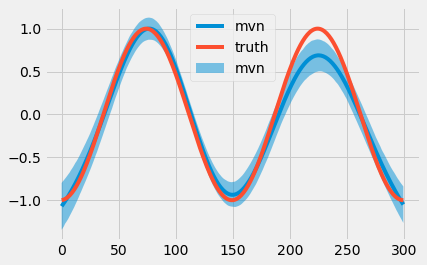

In [166]:
coef_mid, coef_lower, coef_upper  = ktrx1.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='mvn')
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='mvn', alpha=0.5)
plt.plot(data['beta{}'.format(idx)], label='truth')
plt.legend()

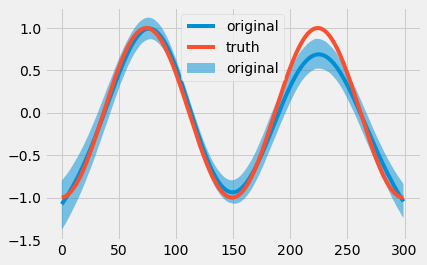

In [170]:
coef_mid, coef_lower, coef_upper  = ktrx2.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='original')
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='original', alpha=0.5)
plt.plot(data['beta{}'.format(idx)], label='truth')
plt.legend()

In [176]:
def multiple_test(N, n, sim_type):
    out = pd.DataFrame()
    out['index'] = range(0, N)
    # for hte model fit 
    out['time_1'] = 0.0
    out['time_2'] = 0.0
    
    out['SSE_1'] = 0.0
    out['SSE_2'] = 0.0
    out['RMSE_1'] = 0.0
    out['RMSE_2'] = 0.0
    out['max_error_1'] = 0.0
    out['max_error_2'] = 0.0
    
    # for the true values 
    out['SSE_beta1_1'] = 0.0
    out['SSE_beta1_2'] = 0.0 
    out['SSE_beta2_1'] = 0.0   
    out['SSE_beta2_2'] = 0.0
    out['SSE_beta3_1'] = 0.0
    out['SSE_beta3_2'] = 0.0

    
    for i in range(0, N):
        # simulate the data 
        if sim_type == 'sea':
            data = sim_data_seasonal(n = n, RS = 1000+i)
       
        if sim_type == 'rw':
            data = sim_data_rw(n = n, RS = 1000+i, p=3)    
    
        #print(data.head())
    
        # define stuff 
        regressor_col=['x1', 'x2', 'x3']
        response_col = 'y'
        # run the model 
        # run lite first 
        ktr_lite = KTRLiteMAP(
            response_col=response_col,
            date_col='date',
            level_knot_scale=1,
            seed=2000+i,
            span_level= .1, 
            estimator_type=StanEstimatorMAP,
        )
        ktr_lite.fit(df=data)
        level_knot_scale = ktr_lite.level_knot_scale
        level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
        level_knot_dates = ktr_lite._level_knot_dates
        level_knots_stan = np.array([0] * len(level_knot_dates))
        
        ktrx1 = KTRXFull(
            response_col=response_col,
            date_col='date',

            degree_of_freedom=30,
            level_knot_scale=level_knot_scale,
            level_knot_dates=level_knot_dates,
            level_knots=level_knots_stan,

            regressor_col=regressor_col,
            regressor_knot_pooling_loc=[0] * len(regressor_col),
            regressor_knot_pooling_scale=[1] * len(regressor_col),
#             regressor_knot_scale=[1.0] * len(regressor_col),

            span_coefficients=0.1,
            rho_coefficients=0.1, 
            prediction_percentiles=[2.5, 97.5],
            seed=2000+i,
            num_steps=1000,
            num_sample=3000,
            verbose=False,
            message=100,
            n_bootstrap_draws=-1,
            estimator_type=PyroEstimatorVI,
            mvn=1
        )

        ktrx2 = KTRXFull(
            response_col=response_col,
            date_col='date',

            degree_of_freedom=30,
            level_knot_scale=level_knot_scale,
            level_knot_dates=level_knot_dates,
            level_knots=level_knots_stan,

            regressor_col=regressor_col,
            regressor_knot_pooling_loc=[0] * len(regressor_col),
            regressor_knot_pooling_scale=[1] * len(regressor_col),
            regressor_knot_scale=[1.0] * len(regressor_col),

            span_coefficients=0.1,
            rho_coefficients=0.1, 
            prediction_percentiles=[2.5, 97.5],
            seed=2000+i,
            num_steps=1000,
            num_sample=3000,
            verbose=False,
            message=100,
            n_bootstrap_draws=-1,
            estimator_type=PyroEstimatorVI,
        )
        
        # fit the models and recod the times
        start_time = time.time()
        ktrx1.fit(df=data)
        time_1 = time.time() - start_time
        
        start_time = time.time()
        ktrx2.fit(df=data)
        time_2 = time.time() - start_time
        
        # get the predictions 
        predicted_df_1 = ktrx1.predict(df=data)
        predicted_df_2 = ktrx2.predict(df=data)
            
        # compare to observations  
        SSE_1 = sum((predicted_df_1['prediction'] - data['y'])**2.0 )
        SSE_2 = sum((predicted_df_2['prediction'] - data['y'])**2.0 )
        
        max_misfit_1 = max(abs(predicted_df_1['prediction'] - data['y']) )
        max_misfit_2 = max(abs(predicted_df_2['prediction'] - data['y']) )
    
        out.at[i, 'time_1'] = time_1 
        out.at[i, 'time_2'] = time_2 
    
        out.at[i, 'SSE_1'] = SSE_1 
        out.at[i, 'SSE_2'] = SSE_2 
        
        out.at[i, 'RMSE_1'] = (SSE_1/n)**(0.5) 
        out.at[i, 'RMSE_2'] = (SSE_2/n)**(0.5) 
        
        
        out.at[i, 'max_error_1'] = max_misfit_1
        out.at[i, 'max_error_2'] = max_misfit_2
        
        #compare to true values 
        coef_df_1= ktrx1.get_regression_coefs(
        aggregate_method='median',
        include_ci=False)
        
        coef_df_2= ktrx2.get_regression_coefs(
        aggregate_method='median',
        include_ci=False)
        
        SSE_beta1_1 = sum((coef_df_1['x1']-data['beta1'])**2.0)
        SSE_beta2_1 = sum((coef_df_1['x2']-data['beta2'])**2.0)
        SSE_beta3_1 = sum((coef_df_1['x3']-data['beta3'])**2.0)
        SSE_beta1_2 = sum((coef_df_2['x1']-data['beta1'])**2.0)
        SSE_beta2_2 = sum((coef_df_2['x2']-data['beta2'])**2.0)
        SSE_beta3_2 = sum((coef_df_2['x3']-data['beta3'])**2.0)    
        
        out.at[i,'SSE_beta1_1'] = SSE_beta1_1
        out.at[i,'SSE_beta2_1'] = SSE_beta2_1
        out.at[i,'SSE_beta3_1'] = SSE_beta3_1
        out.at[i,'SSE_beta1_2'] = SSE_beta1_2
        out.at[i,'SSE_beta2_2'] = SSE_beta2_2
        out.at[i,'SSE_beta3_2'] = SSE_beta3_2
        
    return out


In [177]:
out = multiple_test(N=2, n=300, sim_type='sea')

INFO:root:Guessed max_plate_nesting = 1
INFO:root:Guessed max_plate_nesting = 1
INFO:root:Guessed max_plate_nesting = 1
INFO:root:Guessed max_plate_nesting = 1


In [178]:
out

,index,time_1,time_2,SSE_1,SSE_2,RMSE_1,RMSE_2,max_error_1,max_error_2,SSE_beta1_1,SSE_beta1_2,SSE_beta2_1,SSE_beta2_2,SSE_beta3_1,SSE_beta3_2
0,0,9.966017,10.029054,263.983829,264.119228,0.938054,0.938295,2.688281,2.683877,1.585703,1.649598,1.637195,1.699545,1.107970,1.206316
1,1,9.742971,9.787435,282.864312,305.500343,0.971021,1.009126,2.398460,5.124818,0.733615,0.723862,3.669535,4.097814,2.944355,2.109413


In [ ]:
multiple_test(N=3, n=300, sim_type='rw')